In [1]:
import tensorflow as tf

from tensorflow import keras
from keras import layers

# import evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from script import *

from keras.applications.mobilenet_v2 import preprocess_input

In [2]:
basePath = "D:\\Desktop\\CAB320\\small_flower_dataset\\" # replace with correct path
img_size = 96
x, y, labels = load_data(basePath, img_size)

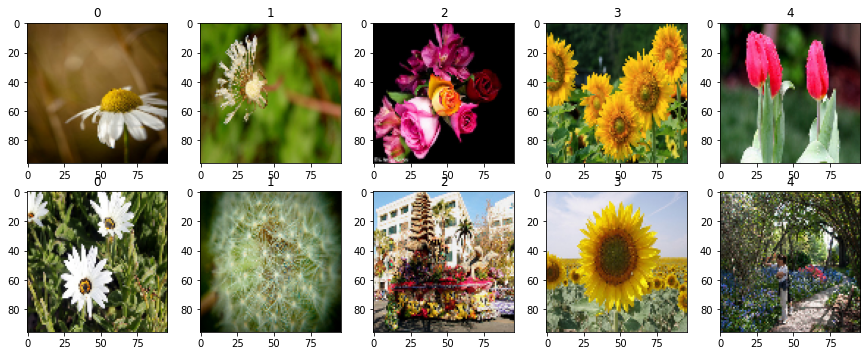

In [3]:
# remove later
plot_images(x, y)

In [4]:
train_X = x[:750]
train_y = y[:750]

test_X = x[750:]
test_y = y[750:]

In [5]:
img_dim = (img_size, img_size, 3)

# using imagenet weights - pretrained model
model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=img_dim,
    alpha=1.0, # control width of network layers (less than 1.0 means decreases no. filters, more than 1.0 means increases no. filters)
    include_top=True, # include fully connected layer
    input_tensor=None, # none
    pooling=None, # maybe we can edit this?
    # classes=5, # default was 1000, maybe we dont need to replace last layer with dense layer of 5 if this is already 5?
    classifier_activation='softmax' # default
)

In [6]:
# connect the second last layer to the new dense layer, replacing the original last dense layer
outputs = layers.Dense(5)(model.layers[-2].output)
new_model = keras.Model(inputs=model.input, outputs=outputs)


# remove later
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [7]:
initial_learning_rate = 0.01 # learning rate they want

optimizer = tf.keras.optimizers.SGD(
    learning_rate=initial_learning_rate, 
    momentum=0.0,
    nesterov=False, 
    name="SGD"
)

In [8]:
# remove later
for layer in new_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001DC1FB93E20> True
<keras.layers.convolutional.Conv2D object at 0x000001DC1FDA0550> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DC1FDA0C40> True
<keras.layers.advanced_activations.ReLU object at 0x000001DC1FDA0C10> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001DC1FE3EE50> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DC1FEADA00> True
<keras.layers.advanced_activations.ReLU object at 0x000001DC1FEADA30> True
<keras.layers.convolutional.Conv2D object at 0x000001DC1FEBFFD0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DC1FECCEB0> True
<keras.layers.convolutional.Conv2D object at 0x000001DC1FECC790> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DC1FED88E0> True
<keras.layers.advanced_activations.ReLU object at 0x000001DC1FED8250> True
<keras

In [9]:
new_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=optimizer,
            metrics=['accuracy'])

In [10]:
history = new_model.fit(train_X, train_y,
                    batch_size=50,
                    epochs=5,
                    validation_split=0.2,
                    validation_batch_size=50
                )

Epoch 1/5
12/12 [==============================] - 7s 443ms/step - loss: 1.2818 - accuracy: 0.4933 - val_loss: 0.9211 - val_accuracy: 0.7000
Epoch 2/5
12/12 [==============================] - 5s 417ms/step - loss: 0.2989 - accuracy: 0.9433 - val_loss: 0.8714 - val_accuracy: 0.6600
Epoch 3/5
12/12 [==============================] - 5s 411ms/step - loss: 0.1510 - accuracy: 0.9883 - val_loss: 0.8414 - val_accuracy: 0.6733
Epoch 4/5
12/12 [==============================] - 5s 412ms/step - loss: 0.0762 - accuracy: 1.0000 - val_loss: 0.8362 - val_accuracy: 0.6600
Epoch 5/5
12/12 [==============================] - 5s 407ms/step - loss: 0.0645 - accuracy: 1.0000 - val_loss: 0.8386 - val_accuracy: 0.6667


In [1]:
def eval_model(model, x_train, y_train, x_test, y_test, history):
    """
    Evaluates the performance of the training and testing set using the provided predictor.
    Code adapted from CAB420 lectures/practicals.

    @param
        model: the predictor
        x_train: the training features data
        y_train: the training ground truths
        x_test: the testing features data
        y_test: the testing ground truths
        history: the history of accuracy and loss over the epochs during the training of the neural network model
    """

    fig = plt.figure(figsize=[21, 6])
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    ax.legend()
    ax.set_title('Training Loss/Accuracy')

    
    ax = fig.add_subplot(1, 3, 2)
    pred = model.predict(x_train);
    best_guesses = tf.argmax(pred, axis=1)
    confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_train, best_guesses), display_labels=range(5))
    confusion_mat.plot(ax = ax)
    ax.set_title('Training Accuracy: ' + str(sum(best_guesses.numpy() == y_train)/len(y_train)));
    
    ax = fig.add_subplot(1, 3, 3)

    pred = model.predict(x_test);

    best_guesses = tf.argmax(pred, axis=1)
    confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, best_guesses), display_labels=range(5))
    confusion_mat.plot(ax = ax)    
    ax.set_title('Testing Accuracy: ' + str(sum(best_guesses.numpy() == y_test)/len(y_test)));

    print(classification_report(y_test, best_guesses))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76        50
           1       0.51      0.98      0.67        50
           2       0.90      0.52      0.66        50
           3       0.89      0.48      0.62        50
           4       0.61      0.68      0.64        50

    accuracy                           0.67       250
   macro avg       0.75      0.67      0.67       250
weighted avg       0.75      0.67      0.67       250



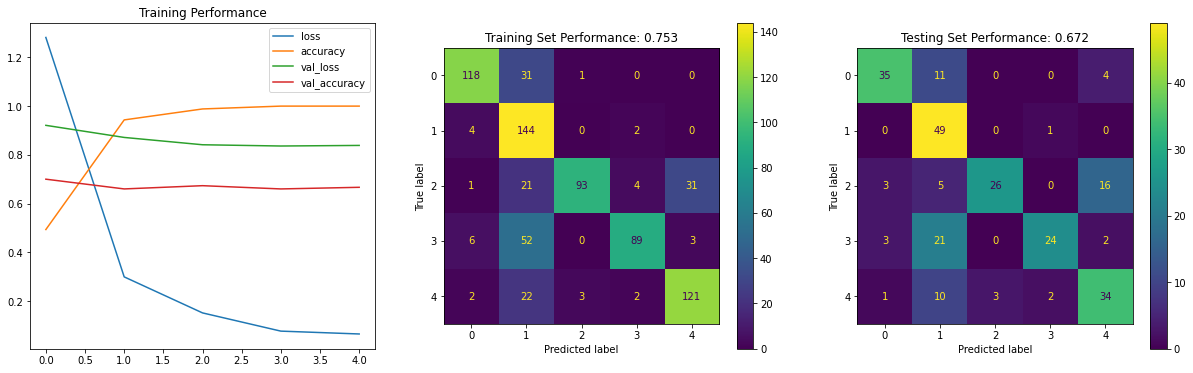

In [12]:
eval_model(new_model, train_X, train_y, test_X, test_y, history)